In [1]:
import wfdb
import pywt
import os
import seaborn
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.signal import butter, lfilter
from scipy.signal import resample_poly
from scipy import stats
from scipy import signal

# 1.wfdb的使用

In [3]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015')
print(record.__dict__)

{'record_name': '04015', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 9205760, 'base_time': datetime.time(9, 0), 'base_date': None, 'comments': [], 'sig_name': ['ECG1', 'ECG2'], 'p_signal': array([[-0.275, -0.21 ],
       [-0.295, -0.2  ],
       [-0.31 , -0.22 ],
       ...,
       [-0.68 , -1.345],
       [-0.67 , -1.23 ],
       [-0.665, -1.165]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['04015.dat', '04015.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-55, -42], 'checksum': [-27172, -28460], 'block_size': [0, 0]}


In [11]:
record = wfdb.rdheader('D:/学习/毕业设计/data/normal/16272')
display(record.__dict__)

{'record_name': '16272',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11520000,
 'base_time': datetime.time(10, 45),
 'base_date': None,
 'comments': ['20 F'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': None,
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16272.dat', '16272.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-37, -17],
 'checksum': [3499, 22174],
 'block_size': [0, 0]}

### record函数
record_name : 储存心电信号的路径;

sampfrom : 起始位置；

sampto : 终止位置；

channels :optional，选择读取某个通道的数据，默认读取全部通道

fs：采样频率；

n_sig：信号通道数；

sig_len：信号长度；

p_signal：模拟信号值，储存形式为ndarray或者是list；

d_signal：数字信号值，储存形式为ndarray或者是list

In [8]:
record=wfdb.rdann('D:/学习/毕业设计/data/abnormal/04015', 'atr' ) 
print(record.__dict__)

{'record_name': '04015', 'extension': 'atr', 'sample': array([     30,  102584,  119604,  121773,  122194,  133348,  166857,
       1096245, 1098054, 1135296, 1139595, 1422436, 1423548, 1459277,
       1460416], dtype=int64), 'symbol': ['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N'], 'fs': 250, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels': None, 'ann_len': 15}


In [ ]:
type=[]
rootdir = 'D:/学习/毕业设计/data/files'           # 设置根路径 
files = os.listdir(rootdir) #列出文件夹下所有的目录与文件
name_list=[]            # name_list=[100,101,...234]
ECG1=[]                 # 用ECG1型导联采集的人
type={}                 # 标记及其数量
for file in files:
    if file[0:5] in name_list:   # 根据数据库实际情况调整熟知，这里判断的是每个文件的前五个字符
        continue
    else:
        name_list.append(file[0:5])
for name in name_list:      # 遍历每一个数据文件
    if name[0] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']:       # 跳过无用的文件
        continue
    elif name in ['00735','03665']:
        continue
    #print(name)
    record = wfdb.rdrecord(rootdir+'/'+name)  # 读取一条记录（100），不用加扩展名
    if 'ECG1' in record.sig_name:       # 这里我们记录MLIII导联的数据（也可以记录其他的，根据数据库的不同选择数据量多的一类导联方式即可）
        ECG1.append(name)               # 记录下这个人
    annotation = wfdb.rdann(rootdir+'/'+name, 'atr')  # 读取一条记录的atr文件，扩展名atr
    for symbol in annotation.symbol:            # 记录下这个人所有的标记类型
        if symbol in list(type.keys()):
            type[symbol]+=1
        else:
            type[symbol]=1
    print('sympbol_name',type)

In [3]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015',channel_names=['ECG1'])
print(record.sig_name)

['ECG1']


In [5]:
lead_index = record.sig_name.index('ECG1')
lead_index

0

In [22]:
record=wfdb.rdrecord('D:/学习/毕业设计/data/normal/16265',channel_names=['ECG1'])
data = record.p_signal.flatten()
annotation = wfdb.rdann('D:/学习/毕业设计/data/normal/16265', 'atr',
                        sampfrom=0,sampto=None,return_label_elements=['symbol'],
                        summarize_labels=False)
Rlocation = annotation.sample
Rclass = annotation.symbol
print(Rlocation)
print(Rclass)
print(annotation.aux_note)
for i in range(0,len(Rlocation)-2):
    print((Rlocation[i+1]-Rlocation[i])/250,'s')

[       1       52      129 ... 10247715 10247823 10247936]
['|', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [ ]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

[[ -55  -42]
 [ -59  -40]
 [ -62  -44]
 ...
 [-136 -269]
 [-134 -246]
 [-133 -233]]


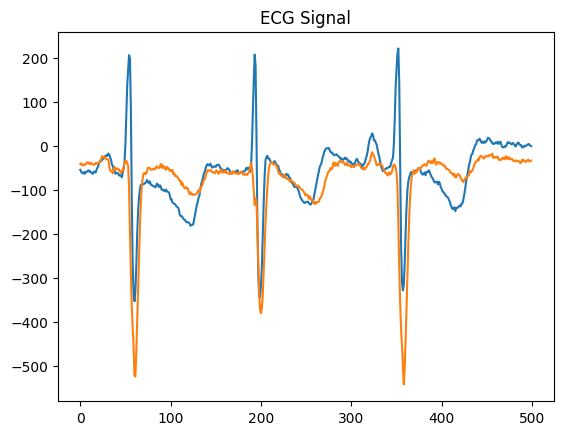

In [3]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015', # 文件所在路径
                       physical=False, # 若为True则读取原始信号p_signal，如果为False则读取数字信号d_signal，默认为False
                       channel_names=['ECG1','ECG2']) # 读取那个通道，也可以用channel_names指定某个通道;如channel_names=['ECG1']

# 转为数字信号
signal = record.d_signal
# 绘制波形
print(signal)
plt.plot(signal[0:500])
plt.title("ECG Signal")
plt.show()

resignal [[-0.006]
 [-0.163]
 [-0.012]
 ...
 [-0.037]
 [-0.071]
 [-0.037]]


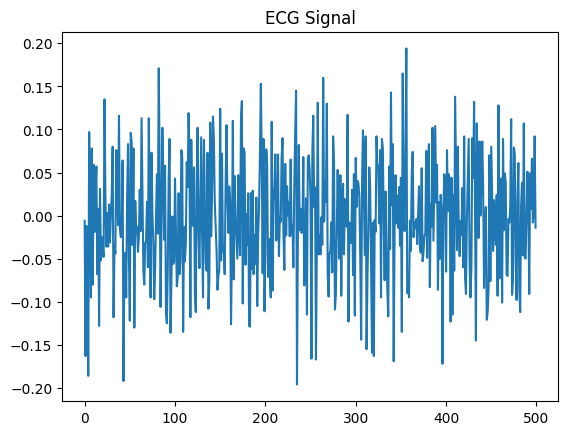

In [21]:
re_signal = scipy.signal.resample(signal, 1280)  # 采样
re_signal_3 = np.round(re_signal, 3)
print('resignal', re_signal_3)
plt.plot(re_signal_3[0:500])
plt.title("ECG Signal")
plt.show()

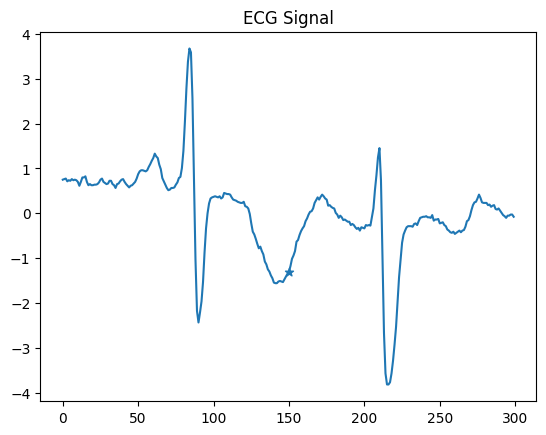

In [57]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015', # 文件所在路径
                       sampfrom=121773-150, # 读取100这个记录的起点，从第0个点开始读
                       sampto=121773+150, # 读取记录的终点，到1000个点结束
                       physical=False, # 若为True则读取原始信号p_signal，如果为False则读取数字信号d_signal，默认为False
                       channel_names=['ECG1']) # 读取那个通道，也可以用channel_names指定某个通道;如channel_names=['MLII']

# 转为数字信号
signal = record.d_signal
signal = stats.zscore(signal)
# 绘制波形
plt.scatter(150, signal[150][0], marker="*")
plt.plot(signal)
plt.title("ECG Signal")
plt.show()

In [ ]:
import wfdb
#显示心跳类型
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

# 2.数据处理

In [ ]:
# 数据位置
root_folder_train = 'D:/学习/毕业设计/data/Train/'
root_folder_test = 'D:/学习/毕业设计/data/Test/'
category = ['normal', 'abnormal']
destination = 'D:/学习/毕业设计/data/'

In [ ]:
def loadData(root_folder, normal_data, abnormal_data):
    for cat in category:
        folder_name = []
        for filename in os.listdir(root_folder + cat):
            # 读取目录下的所有文件
            if filename[0:5] in folder_name:  # 判断文件名的前五个字符
                continue
            else:
                folder_name.append(filename[0:5])
        for name in folder_name:
            if name[0] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']:  # 跳过无用的文件
                continue
            elif name in ['00735', '03665']:  # 跳过不可用文件
                continue
            if cat == 'normal':
                normal_data.append(name)
            elif cat == 'abnormal':
                abnormal_data.append(name)

In [ ]:
normal_data=[]
abnormal_data=[]
loadData(destination,normal_data,abnormal_data)
print(normal_data)
print("------")
print(abnormal_data)

['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']
------
['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']


In [1]:
normal_all = ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453',
                  '18177', '18184', '19088', '19090', '19093', '19140', '19830']
# 正常测试集
normal_set_test = ['19090', '16539', '16773', '18177']
# 正常训练集
normal_set_train = []
for i in normal_all:
    if i not in normal_set_test:
        normal_set_train.append(i)

abnormal_all = ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', 
                '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']
# 不正常测试集
abnormal_set_test = ['08455', '07859', '06453', '04015']
# 不正常训练集
abnormal_set_train = []
for j in abnormal_all:
    if j not in abnormal_set_test:
        abnormal_set_train.append(j)
print(abnormal_set_train)
print(len(abnormal_set_train))

['04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06995', '07162', '07879', '07910', '08215', '08219', '08378', '08405', '08434']
19


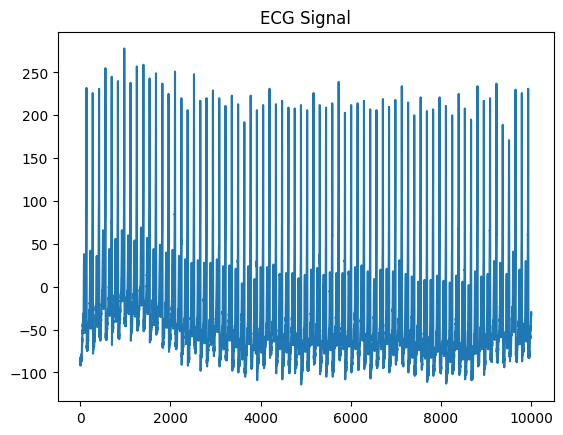

In [25]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04043', # 文件所在路径
                       sampfrom=0, # 读取100这个记录的起点，从第0个点开始读
                       sampto=10000, # 读取记录的终点，到1000个点结束
                       physical=False, # 若为True则读取原始信号p_signal，如果为False则读取数字信号d_signal，默认为False
                       channel_names=['ECG1']) # 读取那个通道，也可以用channel_names指定某个通道;如channel_names=['MLII']

# 转为数字信号
signal = record.d_signal[0:10000]

# 绘制波形
plt.plot(signal)
plt.title("ECG Signal")
plt.show()

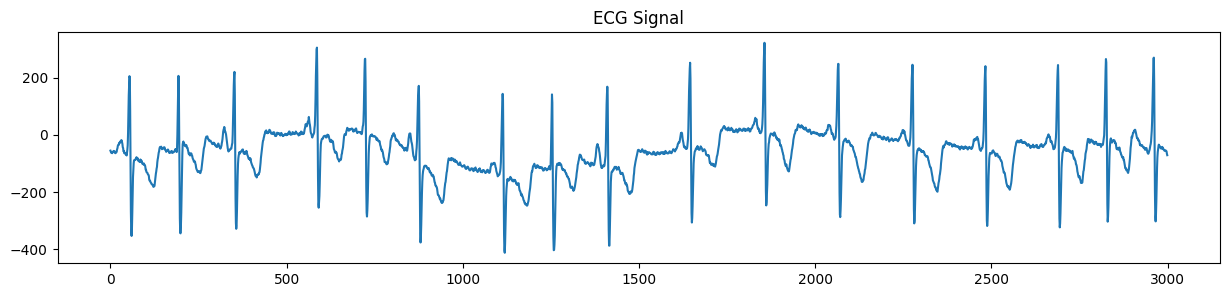

In [13]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015', # 文件所在路径
                       sampfrom=0, # 读取100这个记录的起点，从第0个点开始读
                       sampto=3000, # 读取记录的终点，到1000个点结束
                       physical=False, # 若为True则读取原始信号p_signal，如果为False则读取数字信号d_signal，默认为False
                       channel_names=['ECG1']) # 读取那个通道，也可以用channel_names指定某个通道;如channel_names=['MLII']

# 转为数字信号
signal = record.d_signal

# 绘制波形
plt.figure(figsize=(15, 3))
plt.plot(signal)
plt.title("ECG Signal")


# # 读取annatations
# signal_ann = wfdb.rdann("D:/学习/毕业设计/data/abnormal/04015", "atr", sampfrom=119604, sampto=121773)

# # 将读取到的annatations的心拍绘制到心电图上
# for index in signal_ann.sample:
#     plt.scatter(index, signal[index][0], marker="*")

# # 并打印出改心拍标注的类型
# print(signal_ann.sample[0])
# print(signal_ann.aux_note)
plt.show()

['|', 'N']


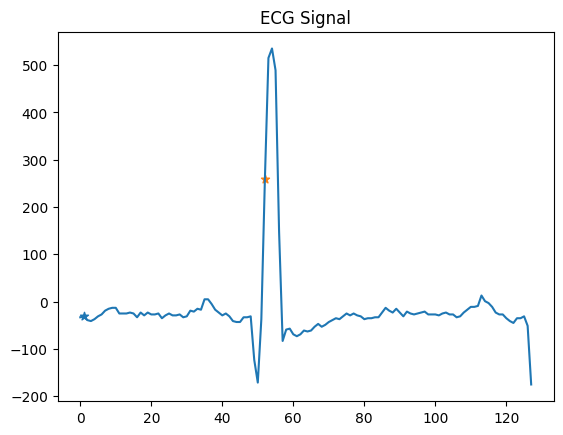

In [6]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/normal/16265', # 文件所在路径
                       sampfrom=0, # 读取100这个记录的起点，从第0个点开始读
                       sampto= 128, # 读取记录的终点，到1000个点结束
                       physical=False, # 若为True则读取原始信号p_signal，如果为False则读取数字信号d_signal，默认为False
                       channel_names=['ECG1']) # 读取那个通道，也可以用channel_names指定某个通道;如channel_names=['MLII']

# 转为数字信号
signal = record.d_signal[0:128]

# 绘制波形
plt.plot(signal)
plt.title("ECG Signal")


# 读取annatations
signal_ann = wfdb.rdann("D:/学习/毕业设计/data/normal/16265", "atr",sampfrom=0,sampto=128)

# 将读取到的annatations的心拍绘制到心电图上
for index in signal_ann.sample:
    # print(index)
    plt.scatter(index, signal[index][0], marker="*")

# 并打印出改心拍标注的类型
print(signal_ann.symbol)
# print(signal_ann.aux_note)
plt.show()

In [ ]:
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

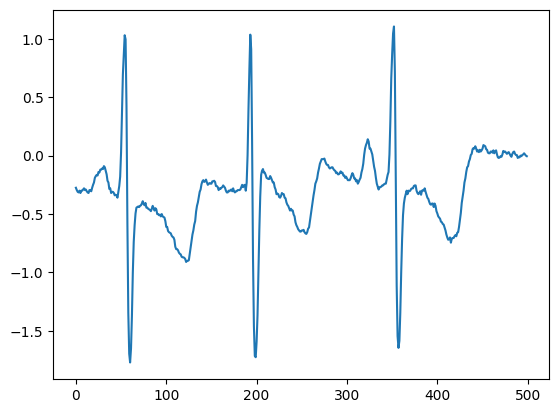

In [ ]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015',channel_names=['ECG1'])
data = record.p_signal.flatten()
rdata = denoise(data=data)
plt.plot(data[0:5000])
plt.show()

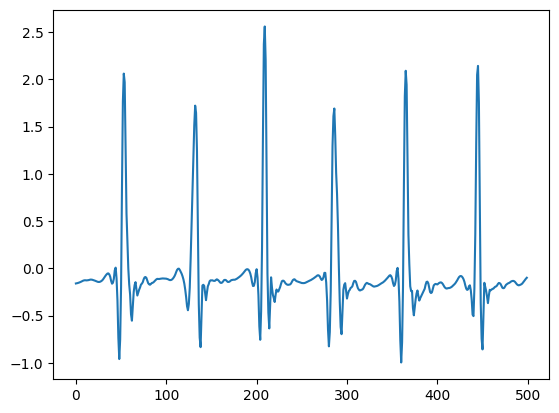

In [ ]:
plt.plot(rdata[0:500])
plt.show()

In [ ]:
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04048',channel_names=['ECG1'])
data = record.p_signal.flatten()
rdata = denoise(data=data)
annotation = wfdb.rdann('D:/学习/毕业设计/data/abnormal/04048', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
start = 10
end = 5
i = 0
j = len(rdata)
print(j)
X_data=[]
Y_data=[]
# 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
# X_data在R波前后截取长度为300的数据点
# Y_data将NAVLR按顺序转换为01234
while i < j:
    try:
        # Rclass[i] 是标签
        x_train = rdata[i:i+300]
        print(len(x_train))
        X_data.append(x_train)
        Y_data.append(1)
        i += 300
    except ValueError:
        i += 300
len(X_data)

[    176  556677  580971  716110  724076 2148473 2153997 2998791 3003178
 3638922 3677438 4157977 4162994 7681741 7686231]
9205760
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
3

30686

In [ ]:
 # 获取心电数据记录中R波的位置和对应的标签
annotation = wfdb.rdann('D:/学习/毕业设计/data/normal/16265', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
# 去掉前后的不稳定数据
start = 10
end = 5
i = start
j = len(annotation.symbol) - end
X_data=[]
Y_data=[]
while i < j:
        try:
            # 基于经验值，基于R峰向前取100个点，向后取200个点
            x_train = rdata[Rlocation[i] - 100:Rlocation[i] + 200]
            print(len(x_train))
            X_data.append(x_train)
            Y_data.append(1)
            i += 1
        except ValueError:
            i += 1
#print(X_data)
print("----------")
#print(len(Y_data))
#print(len(Rlocation))

[       1       52      129 ... 10247715 10247823 10247936]
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from wfdb import processing

# 加载MIT-BIH AFDB数据集
record1 = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015')
annotation = wfdb.rdann('D:/学习/毕业设计/data/abnormal/04015', 'atr')

# 心电图信号滤波，去除基线漂移
filtered_signal = wfdb.processing.baseline_wander_removal(record1.p_signal[:,0], record1.fs)

# 心电图信号标准化
standardized_signal = (filtered_signal - filtered_signal.mean()) / filtered_signal.std()

# 获取QRS波群的位置
qrs_inds = wfdb.processing.qrs.gqrs_detect(standardized_signal, fs=record_data.fs)

# 计算RR间期并滤除异常值
rr_intervals = wfdb.processing.compute_rr_intervals(qrs_inds)
rr_intervals = wfdb.processing.remove_ectopic_beats(rr_intervals)

# 将预处理后的数据保存为WFDB格式
new_record = wfdb.Record(record_name=record1.record_name, fs=record1.fs, 
                            sig_len=len(standardized_signal), n_sig=record1.n_sig, 
                             sig_name=record1.sig_name, p_signal=standardized_signal.reshape(-1,1), 
                             d_signal=None, e_p_signal=None, e_d_signal=None, 
                             comments=record1.comments)


AttributeError: module 'wfdb.processing' has no attribute 'baseline_wander_removal'

In [ ]:
import wfdb
import os

# 设置数据集路径
data_path = 'D:/学习/毕业设计/data/abnormal/'
# 获取所有记录的文件名
records = wfdb.get_record_list('afdb', path=data_path)

# 创建目录用于存储处理后的数据
preprocessed_path = 'D:/学习/毕业设计/data/preprocessed_data'
if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

for record in records:
    # 读取原始数据
    record_data = wfdb.rdrecord(os.path.join(data_path, record))

    # 心电图信号滤波，去除基线漂移
    filtered_signal = wfdb.processing.baseline_wander_removal(record_data.p_signal[:,0], record_data.fs)

    # 心电图信号标准化
    standardized_signal = (filtered_signal - filtered_signal.mean()) / filtered_signal.std()

    # 获取QRS波群的位置
    qrs_inds = wfdb.processing.qrs.gqrs_detect(standardized_signal, fs=record_data.fs)

    # 计算RR间期并滤除异常值
    rr_intervals = wfdb.processing.compute_rr_intervals(qrs_inds)
    rr_intervals = wfdb.processing.remove_ectopic_beats(rr_intervals)

    # 将预处理后的数据保存为WFDB格式
    new_record = wfdb.Record(record_name=record_data.record_name, fs=record_data.fs, 
                             sig_len=len(standardized_signal), n_sig=record_data.n_sig, 
                             sig_name=record_data.sig_name, p_signal=standardized_signal.reshape(-1,1), 
                             d_signal=None, e_p_signal=None, e_d_signal=None, 
                             comments=record_data.comments)

    # 创建目录存储预处理后的数据
    new_record_path = os.path.join(preprocessed_path, record)
    if not os.path.exists(new_record_path):
        os.makedirs(new_record_path)

    # 保存数据到目录
    wfdb.wrrecord(new_record, os.path.join(new_record_path, record), fmt='wfdb')

In [ ]:
import wfdb
import numpy as np

# 读取MIT-BIH数据库中的心电图信号
record = wfdb.rdrecord('mitdb/100')

# 读取相应的注释文件，以获取每个心拍的注释信息
annotation = wfdb.rdann('mitdb/100', 'atr')

# 确定每个心拍的类型是否为房颤
qrs_types = annotation.symbol
non_afib_indices = np.where(qrs_types != 'A')[0]

# 确定每个心拍的位置，并使用这些位置信息切割心电信号，只保留非房颤片段
non_afib_segments = []
for i in range(len(non_afib_indices)):
    if i == 0:
        start_idx = 0
    else:
        start_idx = annotation.sample[non_afib_indices[i-1]]
    end_idx = annotation.sample[non_afib_indices[i]]
    non_afib_segments.append(record.p_signal[start_idx:end_idx])

# non_afib_segments 包含所有非房颤片段的信号，每个元素是一个二维numpy数组，代表一个片段的信号。

# 数据截取与标签

In [4]:
record=wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015',channel_names=['ECG1'])
data = record.p_signal.flatten()
annotation = wfdb.rdann('D:/学习/毕业设计/data/abnormal/04015', 'atr',
                        sampfrom=0,sampto=None,return_label_elements=['symbol'],
                        summarize_labels=False)
Rlocation = annotation.sample
Rclass = annotation.symbol
print(Rlocation)
print(Rclass)
print(annotation.aux_note)

[     30  102584  119604  121773  122194  133348  166857 1096245 1098054
 1135296 1139595 1422436 1423548 1459277 1460416]
['+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+']
['(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N', '(AFIB', '(N']


In [3]:
X_data=[]
# 读取标注文件
annotation = wfdb.rdann('D:/学习/毕业设计/data/abnormal/04908', 'atr')
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04908',channel_names=['ECG1'])
data=record.p_signal.flatten()
# 获取标记符号列表
symbol_list = annotation.aux_note

# 查找所有包含N标记的注释区间
N_ranges = []
N_start = None
for i, symbol in enumerate(symbol_list):
    if symbol == '(N' and N_start is None:
        N_start = annotation.sample[i]
    elif symbol != '(N' and N_start is not None:
        N_end = annotation.sample[i]
        N_ranges.append((N_start, N_end))
        N_start = None

# 如果最后一个注释是N，需要手动添加其结束位置
if N_start is not None:
    N_end = len(data)
    N_ranges.append((N_start, N_end))

# 输出找到的N区间的数量
print('Found %d N segments.' % len(N_ranges))

# 输出找到的N区间的位置
for start, end in N_ranges:
    print('N segment: %d - %d' % (start, end))
    x_train=data[start:end]
    #print('x_train:',x_train[19:2519])
    i=0
    j=len(x_train)-2500
    while i<j:
        tmp_data=x_train[i:i+2500]
        X_data.append(tmp_data)
        i+=2500
print(X_data)
#print('----',data[19:2519])
    

Found 5 N segments.
N segment: 19 - 1227217
N segment: 1329239 - 1744908
N segment: 1945251 - 3399665
N segment: 3724943 - 8591413
N segment: 8797787 - 9205760
[array([ 0.03 ,  0.015,  0.01 , ..., -0.105,  0.09 ,  0.175]), array([0.195, 0.2  , 0.21 , ..., 0.245, 0.265, 0.25 ]), array([0.29 , 0.32 , 0.275, ..., 0.06 , 0.055, 0.06 ]), array([0.04 , 0.06 , 0.065, ..., 0.   , 0.01 , 0.035]), array([ 0.   , -0.015,  0.015, ..., -2.735, -2.525, -2.13 ]), array([-1.455, -0.92 , -0.565, ...,  0.145,  0.14 ,  0.13 ]), array([0.145, 0.15 , 0.16 , ..., 0.31 , 0.31 , 0.305]), array([0.33 , 0.295, 0.295, ..., 0.21 , 0.21 , 0.17 ]), array([0.18 , 0.145, 0.14 , ..., 0.06 , 0.08 , 0.11 ]), array([0.145, 0.2  , 0.2  , ..., 0.07 , 0.065, 0.08 ]), array([0.075, 0.05 , 0.06 , ..., 0.01 , 0.015, 0.065]), array([ 0.155,  0.   , -0.615, ...,  0.235,  0.24 ,  0.275]), array([0.285, 0.28 , 0.295, ..., 0.345, 0.385, 0.415]), array([0.425, 0.41 , 0.43 , ..., 0.48 , 0.5  , 0.465]), array([0.505, 0.5  , 0.505, ...

# 数据预处理

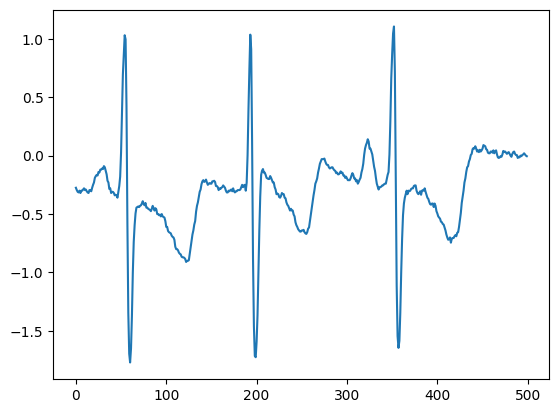

In [11]:
# 读取数据
record = wfdb.rdrecord('D:/学习/毕业设计/data/abnormal/04015',channel_names=['ECG1'])
# 获取心电信号数据和注释信息
data = record.p_signal.flatten()
annotation = wfdb.rdann('D:/学习/毕业设计/data/abnormal/04015', 'atr')
plt.plot(data[0:500])
plt.show()

## 低通滤波

In [12]:
# 设置滤波器参数
nyquist_freq = 0.5 * record.fs
cutoff_freq = 35  # 设置截止频率为35Hz
filter_order = 4  # 设置滤波器阶数为4

# 计算滤波器系数
b, a = butter(filter_order, cutoff_freq/nyquist_freq, btype='low')

# 对信号进行滤波
data_filtered = lfilter(b, a, data)

# 打印原始信号和滤波后的信号的长度
print('Original signal length:', len(data), 'samples')
print('Filtered signal length:', len(data_filtered), 'samples')


Original signal length: 9205760 samples
Filtered signal length: 9205760 samples


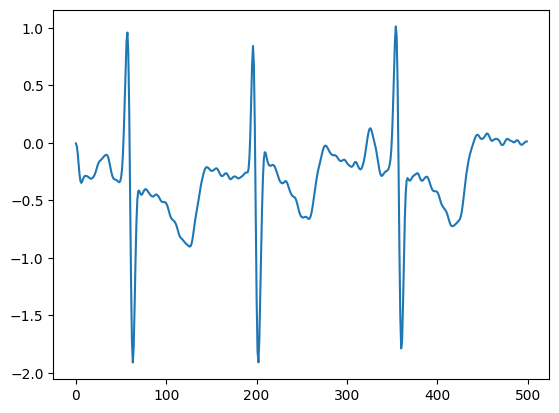

In [13]:
plt.plot(data_filtered[0:500])
plt.show()

## 小波变换

In [14]:
# 小波阈值去噪函数
def wavelet_denoising(data):
    # 小波分解
    coeffs = pywt.wavedec(data, 'db4', level=4)
    # 小波重构
    denoised_data = pywt.waverec(coeffs, 'db4')
    return denoised_data


[-0.00407736 -0.02773411 -0.08861918 ... -0.77559197 -0.69300279
 -0.66763624]


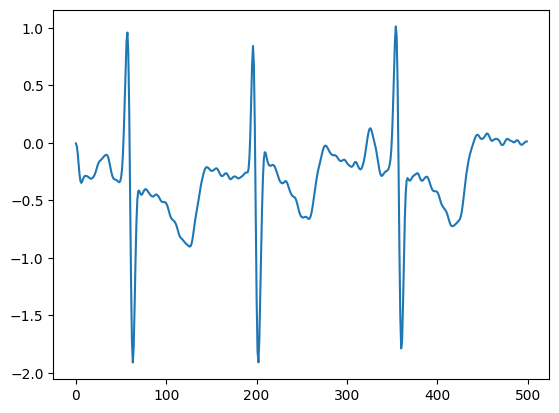

In [15]:
res_data=wavelet_denoising(data_filtered)
print(res_data)
plt.plot(res_data[0:500])
plt.show()

## 归一化

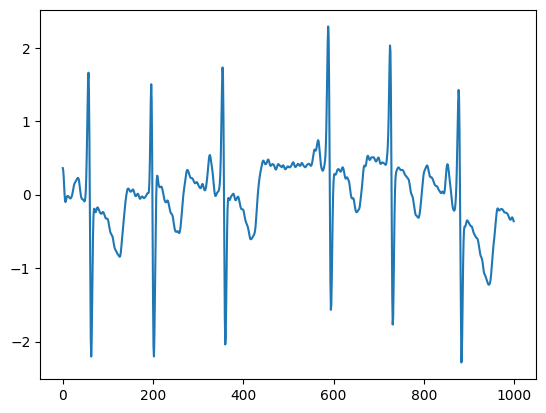

In [16]:
res_data=stats.zscore(res_data)
plt.plot(res_data[0:1000])
plt.show()


## 获取标签和数据片段

In [44]:
X_data=[]
# 获取标记符号列表
symbol_list = annotation.aux_note

# 查找所有包含N标记的注释区间
N_ranges = []
N_start = None
for i, symbol in enumerate(symbol_list):
    if symbol == '(N' and N_start is None:
        N_start = annotation.sample[i]
    elif symbol != '(N' and N_start is not None:
        N_end = annotation.sample[i]
        N_ranges.append((N_start, N_end))
        N_start = None

# 如果最后一个注释是N，需要手动添加其结束位置
if N_start is not None:
    N_end = len(res_data)
    N_ranges.append((N_start, N_end))

# 输出找到的N区间的数量
print('Found %d N segments.' % len(N_ranges))

# 输出找到的N区间的位置
for start, end in N_ranges:
    print('N segment: %d - %d' % (start, end))
    x_ann = wfdb.rdann('D:/学习/毕业设计/data/abnormal/04015', 'qrs', sampfrom=start, sampto=end)
    Rlocation=x_ann.sample
    #print('x_train:',x_train[19:2519])
    i=10
    j=len(Rlocation)-5
    print("len",len(Rlocation))
    while i<j:
        tmp_data=res_data[Rlocation[i]-100:Rlocation[i]+200]
        X_data.append(tmp_data)
        i+=1
print(len(X_data))
#print('----',data[19:2519])
    

Found 8 N segments.
N segment: 30 - 102584
len 612
N segment: 119604 - 121773
len 13
N segment: 122194 - 133348
len 71
N segment: 166857 - 1096245
len 5018
N segment: 1098054 - 1135296
len 204
N segment: 1139595 - 1422436
len 1602
N segment: 1423548 - 1459277
len 188
N segment: 1460416 - 9205760
len 35772
43362


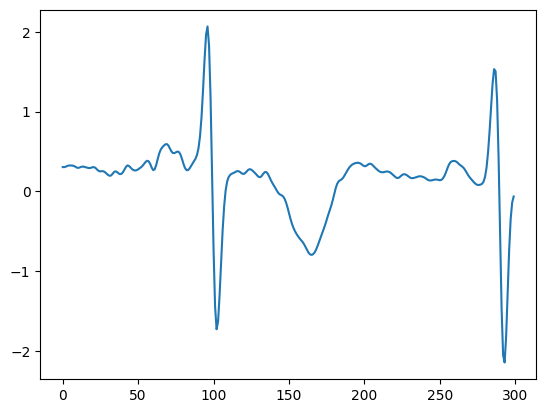

In [45]:
plt.plot(X_data[1000])
plt.show()

## 重采样

In [18]:
# 将信号重采样为128Hz
old_fs = record.fs
new_fs = 128
data_resampled = resample_poly(res_data, new_fs, old_fs)

# 打印原始信号和重采样后的信号的长度和采样率
print('Original signal length:', len(res_data), 'samples')
print('Original sampling rate:', old_fs, 'Hz')
print('Resampled signal length:', len(data_resampled), 'samples')
print('Resampled sampling rate:', new_fs, 'Hz')

Original signal length: 9205760 samples
Original sampling rate: 250 Hz
Resampled signal length: 4713350 samples
Resampled sampling rate: 128 Hz


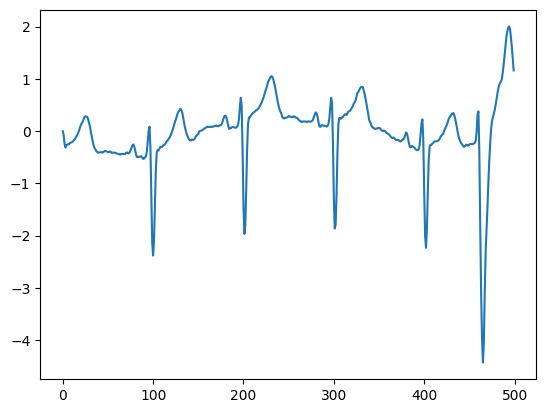

In [19]:
plt.plot(data_resampled[0:500])
plt.show()

## 将心电信号片段切割为10s

In [ ]:
ormal_list = [i for i, x in enumerate(annotation.aux_note) if x == '(N']

## 截取心电信号片段

In [ ]:
import wfdb
import numpy as np

# 读取数据
record = wfdb.rdrecord('mitdb/100', sampfrom=0, sampto=None, channels=None, physical=True, pbdir=None)

# 获取心电信号数据和注释信息
data = record.p_signal[:, 0]
annotation = wfdb.rdann('mitdb/100', 'atr')

# 将心电数据截取为同样长度（5000个样本点），并在过长和缺失时进行处理
target_len = 5000
if len(data) > target_len:
    data = data[:target_len]
else:
    zeros_arr = np.zeros(target_len)
    zeros_arr[:len(data)] = data
    data = zeros_arr

# 打印处理后的数据长度
print(len(data))
